# Dependencies

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import gurobipy as gp

In [3]:
data_path = Path("../data_will/48_Industry_Portfolios.CSV")
df = pd.read_csv(data_path, index_col=0)
df.index = pd.to_datetime(df.index, format="%Y%m")  # clean the index to be datetime

# constants
start_date = "2019-12-01"
N = 48
df = df.loc[df.index >= start_date, :]  # select last 5 years

df = df.astype(dtype= 'float32')

df = df / 100

df.describe()


,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,...,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,0.017117,0.004980,0.008265,0.005168,0.012857,-0.002565,0.013780,0.012487,0.006888,0.004733,...,0.008648,0.011645,0.015997,0.014975,0.011153,0.011702,0.013062,0.014083,0.018372,0.013975
std,0.068090,0.041918,0.050762,0.045067,0.056757,0.094535,0.088800,0.077713,0.048038,0.082384,...,0.059486,0.071240,0.061131,0.061295,0.064055,0.074754,0.051455,0.097738,0.070738,0.056051
min,-0.125100,-0.093000,-0.154400,-0.099200,-0.116200,-0.188500,-0.279700,-0.226500,-0.105900,-0.194600,...,-0.138000,-0.168100,-0.178200,-0.112400,-0.221200,-0.239000,-0.127400,-0.359500,-0.168600,-0.149900
25%,-0.030700,-0.023925,-0.015550,-0.028725,-0.023175,-0.060700,-0.038925,-0.042650,-0.018525,-0.059300,...,-0.036100,-0.042750,-0.016550,-0.030900,-0.023300,-0.033625,-0.029450,-0.032525,-0.035075,-0.023475
50%,0.024450,0.002900,0.010700,0.003000,0.014450,-0.009550,0.014250,0.012900,0.004050,0.005200,...,0.008700,0.005900,0.010850,0.015900,0.006100,0.018150,0.015600,0.008500,0.021150,0.014450
75%,0.058475,0.034500,0.043800,0.032550,0.052675,0.057050,0.074425,0.052650,0.038350,0.058750,...,0.056400,0.075450,0.053275,0.052125,0.053550,0.055125,0.037825,0.066825,0.065800,0.055175
max,0.161600,0.112600,0.126800,0.110900,0.124200,0.210600,0.193300,0.238000,0.114000,0.175100,...,0.117900,0.174400,0.161100,0.187900,0.186700,0.183100,0.128200,0.214200,0.168800,0.166100


In [3]:
# QUESTION 1
cov = df.cov()
mean = df.mean(axis=0)
std = np.sqrt(np.diag(cov))
ret = 1
K = 5
l = 9 #max position size (500%)

# Create an empty optimization model
m = gp.Model()
m.Params.LogToConsole = 0

# Add variables: x[i] denotes the proportion of capital invested in stock i
# 0 <= x[i] <= 1
x = m.addMVar(len(mean), lb=-np.inf, ub=np.inf, name="x")
x_plus = m.addMVar(len(mean), lb= 0, ub=np.inf, name="x_plus")
x_minus = m.addMVar(len(mean), lb= 0, ub=np.inf, name="x_minus")
b = m.addMVar(len(mean), vtype=gp.GRB.BINARY, name="b")

# Budget constraint: all investments sum up to 1
m.addConstr(x.sum() == 1, name="Budget_Constraint")
m.addConstr(x == x_plus - x_minus, name= "Position_Balance")
m.addConstr(x_plus <= l*b, name= "Long_Indicator")
m.addConstr(x_minus <= l*b, name= "Short_Indicator")
m.addConstr(b.sum() <= K, name="Cardinality")
m.addConstr(mean.to_numpy() @ x >= ret , name="Target_Return")

# Define objective function: Minimize overall risk
m.setObjective(x.T @ cov.to_numpy() @ x, gp.GRB.MINIMIZE)

Restricted license - for non-production use only - expires 2026-11-23
Set parameter LogToConsole to value 0


In [4]:
m.optimize()

In [5]:
print(f"Minimum risk:     {m.ObjVal:.6f}")
print(f"Expected return:  {mean @ x.X:.6f}")
print(f"Solution time:    {m.Runtime:.2f} seconds\n")

# Print investments (with non-negligible value, i.e., > 1e-5)
positions = pd.Series(name="Position", data= x.X, index= mean.index)
print(f"Number of assets: {positions[abs(positions) > 1e-5].count()}\n")
print(positions[abs(positions) > 1e-5])
index = positions[abs(positions) > 1e-5].index
result = pd.DataFrame({'mean' : df[index].mean(),
                       'var' : df[index].var()})
print(result)

Minimum risk:     11.368631
Expected return:  1.000000
Solution time:    2.66 seconds

Number of assets: 5

Agric    0.224955
Food     0.631956
Drugs    0.377866
Chems   -0.441284
BusSv    0.206507
Name: Position, dtype: float64
           mean        var
Agric  1.711667  46.361992
Food   0.498000  17.571199
Drugs  0.908667  18.986731
Chems  0.822667  48.662903
BusSv  1.549167  38.129124


# Problem 3

### Maximum Sharpe Ratio Portfolio (i.e., Tangency Portfolio)

A particular portfolio on the efficient side of the mean-variance frontier constructed using risky assets is the tangency portfolio. This portfolio lies on the mean-variance frontier of risky assets and achieves the maximum possible Sharpe ratio.

#### Optimization Problem:

Maximize (over **x**):
$$
\frac{\mathbf{x}'(\mathbb{E}[R] - r_f)}{\sqrt{\mathbf{x}'\Sigma \mathbf{x}}}
$$

Subject to:
$$
\sum x_i = 1
$$


In [4]:
# QUESTION 1
cov = df.cov()
mean = df.mean(axis=0)
std = np.sqrt(np.diag(cov))
ret = 0.03
K = 5
l = 5 #max position size (500%)


# Create an empty optimization model
m = gp.Model()
m.Params.Threads=8

# Add variables: x[i] denotes the proportion of capital invested in stock i
# 0 <= x[i] <= 1
x = m.addMVar(len(mean), lb=-np.inf, ub=np.inf, name="x")
x_plus = m.addMVar(len(mean), lb= 0, ub=np.inf, name="x_plus")
x_minus = m.addMVar(len(mean), lb= 0, ub=np.inf, name="x_minus")
b = m.addMVar(len(mean), vtype=gp.GRB.BINARY, name="b")

# Budget constraint: all investments sum up to 1
m.addConstr(x.sum() == 1, name="Budget_Constraint")
m.addConstr(x == x_plus - x_minus, name= "Position_Balance")
m.addConstr(x_plus <= l*b, name= "Long_Indicator")
m.addConstr(x_minus <= l*b, name= "Short_Indicator")
m.addConstr(b.sum() <= K, name="Cardinality")
m.addConstr(x.T @ mean.to_numpy() >= ret , name="Target_Return")

# Maxmize the rReturns
m.setObjective(x.T @ cov.to_numpy() @ x, gp.GRB.MINIMIZE)

Restricted license - for non-production use only - expires 2026-11-23
Set parameter Threads to value 8


In [5]:
m.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 7 3800X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 8 threads

Non-default parameters:
Threads  8

Optimize a model with 147 rows, 192 columns and 480 nonzeros
Model fingerprint: 0x544ccc77
Model has 1176 quadratic objective terms
Variable types: 144 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [3e-03, 5e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-02, 5e+00]
Found heuristic solution: objective 0.0150301
Presolve time: 0.02s
Presolved: 147 rows, 192 columns, 479 nonzeros
Presolved model has 1176 quadratic objective terms
Variable types: 144 continuous, 48 integer (48 binary)

Root relaxation: objective 3.266972e-04, 361 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node   

In [6]:
try:
    var = x.X @ cov.to_numpy() @ x.X
    rets = mean @ x.X
    SR = rets/np.sqrt(var)


    positions = pd.Series(name="Position", data= x.X, index= mean.index)
    index = positions[abs(positions) > 1e-5].index
    result = pd.DataFrame({'mean' : df[index].mean(),
                        'var' : df[index].var()})
except:
    rets = 0

print(f"Sharpe Ratio:     {rets / np.sqrt(var)}")
print(f"Expected return:  {rets:.6f}")
print(f"Variance :  {var:.6f}")
print(f"Solution time:    {m.Runtime:.2f} seconds\n")

# Print investments (with non-negligible value, i.e., > 1e-5)
positions = pd.Series(name="Position", data= x.X, index= mean.index)
print(f"Number of assets: {positions[abs(positions) > 1e-5].count()}\n")
print(positions[abs(positions) > 1e-5])
index = positions[abs(positions) > 1e-5].index
result = pd.DataFrame({'mean' : df[index].mean(),
                       'var' : df[index].var()})
print(result)

Sharpe Ratio:     0.5750810948247996
Expected return:  0.030000
Variance :  0.002721
Solution time:    4.80 seconds

Number of assets: 5

Hlth    -0.994917
Drugs    1.319945
BldMt    0.852698
Util     0.918215
Paper   -1.095942
Name: Position, dtype: float64
           mean       var
Hlth   0.004975  0.005164
Drugs  0.009087  0.001899
BldMt  0.020390  0.006759
Util   0.009712  0.002639
Paper  0.003055  0.003033


# Without Short Selling

In [1]:
# QUESTION 1
cov = df.cov()
mean = df.mean(axis=0)
std = np.sqrt(np.diag(cov))
ret = 1
K = 5
l = 5 #max position size (500%)
ret = 0.03 #example of a variance

# Create an empty optimization model
m = gp.Model()
m.Params.Threads=8

# Add variables: x[i] denotes the proportion of capital invested in stock i
# 0 <= x[i] <= 1
x = m.addMVar(len(mean), lb=0, ub=np.inf, name="x")
b = m.addMVar(len(mean), vtype=gp.GRB.BINARY, name="b")

# Budget constraint: all investments sum up to 1
m.addConstr(x.sum() == 1, name="Budget_Constraint")
m.addConstr(x <= l*b, name= "Long_Indicator")
m.addConstr(b.sum() <= K, name="Cardinality")
m.addConstr(x.T @ mean.to_numpy() >= ret , name="Target_Return")

# Maxmize the rReturns
m.setObjective(x.T @ cov.to_numpy() @ x, gp.GRB.MINIMIZE)

NameError: name 'df' is not defined

In [36]:
m.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 7 3800X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 8 threads

Non-default parameters:
Threads  8

Optimize a model with 51 rows, 96 columns and 240 nonzeros
Model fingerprint: 0xc64f965a
Model has 1176 quadratic objective terms
Variable types: 48 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [3e-03, 5e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-02, 5e+00]
Presolve time: 0.00s
Presolved: 51 rows, 96 columns, 239 nonzeros
Presolved model has 1176 quadratic objective terms
Variable types: 48 continuous, 48 integer (48 binary)

Root relaxation: objective 5.664767e-03, 24 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl 

In [37]:
try:
    var = x.X @ cov.to_numpy() @ x.X
    rets = mean @ x.X
    SR = rets/np.sqrt(var)


    positions = pd.Series(name="Position", data= x.X, index= mean.index)
    index = positions[abs(positions) > 1e-5].index
    result = pd.DataFrame({'mean' : df[index].mean(),
                        'var' : df[index].var()})
except:
    rets = 0

print(f"Sharpe Ratio:     {rets / np.sqrt(var)}")
print(f"Expected return:  {rets:.6f}")
print(f"Variance :  {var:.6f}")
print(f"Solution time:    {m.Runtime:.2f} seconds\n")

# Print investments (with non-negligible value, i.e., > 1e-5)
positions = pd.Series(name="Position", data= x.X, index= mean.index)
print(f"Number of assets: {positions[abs(positions) > 1e-5].count()}\n")
print(positions[abs(positions) > 1e-5])
index = positions[abs(positions) > 1e-5].index
result = pd.DataFrame({'mean' : df[index].mean(),
                       'var' : df[index].var()})
print(result)

Sharpe Ratio:     0.3985935312039446
Expected return:  0.030000
Variance :  0.005665
Solution time:    0.01 seconds

Number of assets: 3

Autos    0.033243
Coal     0.310189
Chips    0.656568
Name: Position, dtype: float64
           mean       var
Autos  0.037858  0.025154
Coal   0.035698  0.019848
Chips  0.026910  0.005822


In [7]:
def max_sharpe_ratio(df: pd.DataFrame, exp_return: float, short_constraint: bool) -> tuple:
    """ 
    Computes the maximum sharpe ratio for a given return

    Inputs
        df: dataframe of monthly returns, each colum is a different asset
        exp_return: expected return for the sharpe ratio
        short_constraint: if the short constraint is active
    
    Outputs
        x: weights of the assets
        SR: max Sharpe Ratio for the return
        result: dataframe of positions 
    """
    cov = df.cov()
    mean = df.mean(axis=0)

    K = 5
    l = 5 #max position size (500%)

    # Create an empty optimization model
    m = gp.Model()
    m.setParam('OutputFlag', 0)
    m.Params.Threads=8

    # Add variables: x[i] denotes the proportion of capital invested in stock i
    
    b = m.addMVar(len(mean), vtype=gp.GRB.BINARY, name="b")

    if short_constraint:
        x = m.addMVar(len(mean), lb=-np.inf, ub=np.inf, name="x")
        x_plus = m.addMVar(len(mean), lb= 0, ub=np.inf, name="x_plus")
        x_minus = m.addMVar(len(mean), lb= 0, ub=np.inf, name="x_minus")

        # Budget constraint: all investments sum up to 1
        m.addConstr(x == x_plus - x_minus, name= "Position_Balance")
        m.addConstr(x_plus <= l*b, name= "Long_Indicator")
        m.addConstr(x_minus <= l*b, name= "Short_Indicator")
    else:
        x = m.addMVar(len(mean), lb=0, ub=np.inf, name="x")
        m.addConstr(x <= l*b, name= "Long_Indicator")

    # Budget constraint: all investments sum up to 1
    
    m.addConstr(x.sum() == 1, name="Budget_Constraint")
    m.addConstr(b.sum() <= K, name="Cardinality")
    m.addConstr(x.T @ mean.to_numpy() >= exp_return , name="Target_Return")

    # Minimize variance
    m.setObjective(x.T @ cov.to_numpy() @ x, gp.GRB.MINIMIZE)

    m.optimize()

    try:
        var = x.X @ cov.to_numpy() @ x.X
        rets = mean @ x.X
        SR = rets/np.sqrt(var)

        positions = pd.Series(name="Position", data= x.X, index= mean.index)
        index = positions[abs(positions) > 1e-5].index
        result = pd.DataFrame({'mean' : df[index].mean(),
                                'var' : df[index].var()})
    except:
        SR= None
        x = None
        result = None

    return SR, x, result

SR, _, _ = max_sharpe_ratio(df, 0.03, short_constraint= True)
SR

np.float64(0.5750810948247996)

In [8]:
rets = np.linspace(0, 0.4, 150)
sharpe = np.zeros(len(rets))
for i in range(len(rets)):
    SR, _, _ = max_sharpe_ratio(df= df, exp_return= rets[i], short_constraint= True)
    sharpe[i] = SR

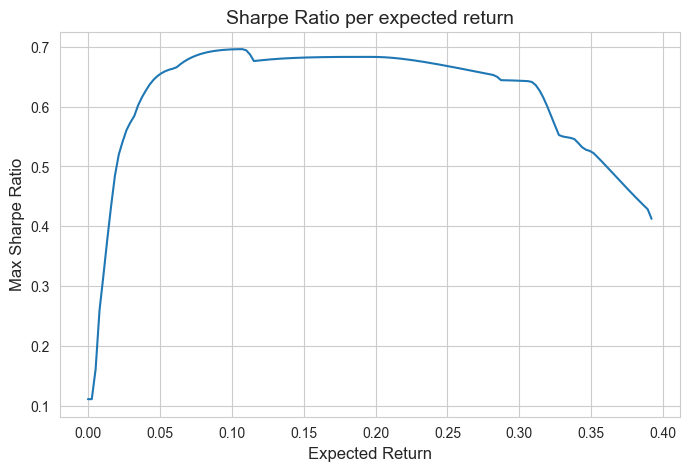

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(8, 5))
sns.lineplot(y=sharpe, x= rets)
# Add Title and Labels
plt.title("Sharpe Ratio per expected return", fontsize=14)
plt.xlabel("Expected Return", fontsize=12)
plt.ylabel("Max Sharpe Ratio", fontsize=12)

# Show the Plot
plt.show()